In [291]:
from polygon import RESTClient
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

#works best with constant markets. Does not perform well with bullish or bearish markets

class SimpleMovingAverage:
  def __init__(self, typ, period):
    self.period = period
    self.typ = typ
    self.data = []
    self.avg = -1 # needs updating - at least 1 day(s) of data required
  
  def update(self, new_delta):
    if self.typ == "gain" and new_delta < 0:
      new_delta = 0
    elif self.typ == "loss" and new_delta > 0:
      new_delta = 0
    self.data.append(abs(new_delta))
    if len(self.data) > self.period:
      self.data.pop(0)
    self.avg = sum(self.data) / len(self.data)
  
class RelativeStrengthIndex:
  def __init__(self, period=14):
    self.period = period
    self.last = -1
    self.rsi = -1 # needs updating - more than [period=14] day(s) of data required
    self.count = 0
    self.gain_avg = SimpleMovingAverage("gain", period)
    self.loss_avg = SimpleMovingAverage("loss", period)
  
  def update(self, new_data_point, time=""):
    if self.last >= 0:
      self.gain_avg.update(new_data_point - self.last)
      self.loss_avg.update(new_data_point - self.last)
    self.last = new_data_point
    self.count += 1
    if self.count > self.period:
      self.rsi = 100 - (100 / (1 + self.gain_avg.avg / (0.000000000000000000001 + self.loss_avg.avg)))

def generate_date_array(year):
    dates = []
    # Start from the first day of the given year
    current_date = datetime(year, 1, 1)
    # End on the last day of the given year
    end_date = datetime(year + 1, 1, 1)
    
    while current_date < end_date:
        # Format the date as "yyyy-mm-dd" and add it to the list
        date_string = current_date.strftime("%Y-%m-%d")
        dates.append(date_string)
        # Move to the next day
        current_date += timedelta(days=1)
    
    return dates

def graph_profits(data, type_of_profit):
    # Extract keys and values
    dates = list(data.keys())
    values = list(data.values())

    # Convert string dates to datetime objects
    dates = [datetime.strptime(date, '%Y-%m-%d') for date in dates]

    # Create a plot
    plt.figure(figsize=(8, 4))
    plt.plot(dates, values, marker='o', linestyle='-', color='b')

    # Format the x-axis to show dates properly
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.DayLocator())

    # Label the axes
    plt.xlabel('Date')
    plt.ylabel(type_of_profit)
    plt.title(f'Model {type_of_profit} vs Holding Stock')

    # Rotate date labels for better readability
    plt.xticks(rotation=45)

    # Show grid
    plt.grid(True)

    # Display the plot
    plt.tight_layout()
    plt.show()


def graph_transactions(transactions):
  # Convert transactions to a DataFrame for easier manipulation
  df = pd.DataFrame(transactions, columns=['Date', 'Price', 'Type'])

  # Convert the 'Date' column to datetime objects
  df['Date'] = pd.to_datetime(df['Date'])

  # Separate the transactions by type
  sell_transactions = df[df['Type'] == 'Sell']
  buy_transactions = df[df['Type'] == 'Buy']

  # Plotting
  plt.figure(figsize=(10, 6))

  # Plot sell transactions in red
  plt.scatter(sell_transactions['Date'], sell_transactions['Price'], color='red', label='Sell', marker='x')

  # Plot buy transactions in green
  plt.scatter(buy_transactions['Date'], buy_transactions['Price'], color='green', label='Buy', marker='o')

  # Labels and title
  plt.xlabel('Date')
  plt.ylabel('Price')
  plt.title('Transaction Prices Over Time')
  plt.legend()

  # Format the date on the x-axis
  plt.gcf().autofmt_xdate()

  # Show the plot
  plt.show()

In [292]:
def get_data(ticker, start_date, end_date):
    client = RESTClient("InxdvvQ5aFMwk5xWUpJUCpe8YHcimh8d")
    aggs = client.get_aggs(ticker, 1, "minute", start_date, end_date, limit=50000)
    print("Number of Data Points:",len(aggs))
    return aggs
    
    

In [293]:
def run_simulation(ticker, start_date, end_date, init_cash, init_shares, percent_invest, prices, times, buys, sells):
  transaction_times = sorted(buys + sells)
  transactions = []
  for t in transaction_times:
    price = prices[times.index(t)]
    if t in buys:
      transactions.append([t, price, "Buy"])
    else:
      transactions.append([t, price, "Sell"])
      
  print("Transactions: ", transactions)
  graph_transactions(transactions)
  # Execute Transactions through simulation
  cash = init_cash
  shares = init_shares
  print("Running Simulation for RSI with", ticker, "from", start_date, "to", end_date)
  print("Number of Transactions: ", len(transactions))
  print("Buys: ", len(buys), "Sells: ", len(sells))
  print("Open Price, Close Price: ", prices[0], prices[-1])
  print("Beginning Cash and Shares: ", cash, shares)
  portfolio_val_s = cash + prices[0] * shares
  print("Beginning Portfolio Value: ", portfolio_val_s)
  amt = cash * percent_invest / 100
  for order in transactions:
    if order[2] == "Buy":
      cash -= amt
      shares += amt/order[1]
    else:
      cash += amt
      shares -= amt/order[1]
  print("End Cash and Shares: ", cash, shares)
  portfolio_val_e = cash + prices[-1] * shares
  profit = portfolio_val_e - portfolio_val_s
  profit_percentage = (portfolio_val_e - portfolio_val_s) / portfolio_val_s * 100

  base_profit_percentage = init_shares*(prices[-1]-prices[0])/portfolio_val_s * 100

  print("End Portfolio Value: ", portfolio_val_e)
  print()
  print()
  print("Model Profit Percentage: ", profit_percentage)
  print("Market Change w/o trades", base_profit_percentage)
  print("Model outperforms market by", (profit_percentage - base_profit_percentage), "%") 


  return [cash, shares, profit, profit_percentage, base_profit_percentage]

In [294]:
def invest_rsi(ticker, start_date, end_date, cash=100000, shares=1000, percent_invest=20):
  aggs = get_data(ticker, start_date, end_date)
  x_close = []
  y_close = []
  min_diff = 1
  for i in range(0, len(aggs), min_diff):
    agg = aggs[i]
    x_close.append(datetime.fromtimestamp(agg.timestamp // 1000).strftime("%Y-%m-%d %H:%M"))
    y_close.append(agg.close)

  
  #check if there is data for this time period
  if len(y_close) == 0:
    print("no data for this time period and stock")
    return(cash, shares, 0, 0, 0)

  # RSI execution
  rsi = RelativeStrengthIndex()
  last_rsi = -1
  buys = []
  sells = []
  
  # Parameters for trade strategy/execution
  low_threshold = 15
  high_threshold = 85
  
  for time, point in zip(x_close, y_close):
    rsi.update(point, time)
    if rsi.count > rsi.period:
      if last_rsi < 0:
        last_rsi = rsi.rsi
      if last_rsi < low_threshold and rsi.rsi >= low_threshold:
        buys.append(time)
      if last_rsi > high_threshold and rsi.rsi <= high_threshold:
        sells.append(time)
      last_rsi = rsi.rsi

  return run_simulation(ticker, start_date, end_date, cash, shares, percent_invest, y_close, x_close, buys, sells)


In [295]:
def test_model(ticker, start_date, end_date, init_cash, init_shares, percent_invest):
    year1 = int(start_date[:4])
    year2 = int(end_date[:4])
    date_array = []
    for year in range(year1, year2+1):
        date_array += generate_date_array(year)

    
    cash, shares, profit, profit_percentage, base_profit_percentage = invest_rsi(ticker, start_date, end_date, init_cash, init_shares, percent_invest)
    alpha = profit_percentage - base_profit_percentage

    return alpha, profit_percentage



Number of Data Points: 31954
Transactions:  [['2024-01-02 05:27', 190.05, 'Sell'], ['2024-01-02 06:02', 189.39, 'Buy'], ['2024-01-02 06:33', 188.9, 'Buy'], ['2024-01-02 09:00', 188.1, 'Buy'], ['2024-01-02 09:05', 187.98, 'Buy'], ['2024-01-02 10:39', 185.6, 'Buy'], ['2024-01-02 11:33', 186.9799, 'Sell'], ['2024-01-02 11:35', 186.97, 'Sell'], ['2024-01-02 11:38', 187.215, 'Sell'], ['2024-01-02 13:01', 185.9247, 'Buy'], ['2024-01-02 15:55', 185.335, 'Sell'], ['2024-01-02 16:02', 185.63, 'Sell'], ['2024-01-02 18:25', 185.36, 'Buy'], ['2024-01-02 19:13', 185.24, 'Buy'], ['2024-01-03 07:00', 184.98, 'Sell'], ['2024-01-03 07:28', 184.67, 'Buy'], ['2024-01-03 09:17', 184.12, 'Buy'], ['2024-01-03 10:26', 183.84, 'Buy'], ['2024-01-03 11:53', 183.68, 'Buy'], ['2024-01-03 17:11', 184.1, 'Buy'], ['2024-01-03 19:48', 184.18, 'Sell'], ['2024-01-03 19:56', 184.25, 'Sell'], ['2024-01-04 04:05', 182.97, 'Buy'], ['2024-01-04 04:21', 183.07, 'Sell'], ['2024-01-04 04:49', 183, 'Sell'], ['2024-01-04 06:20',

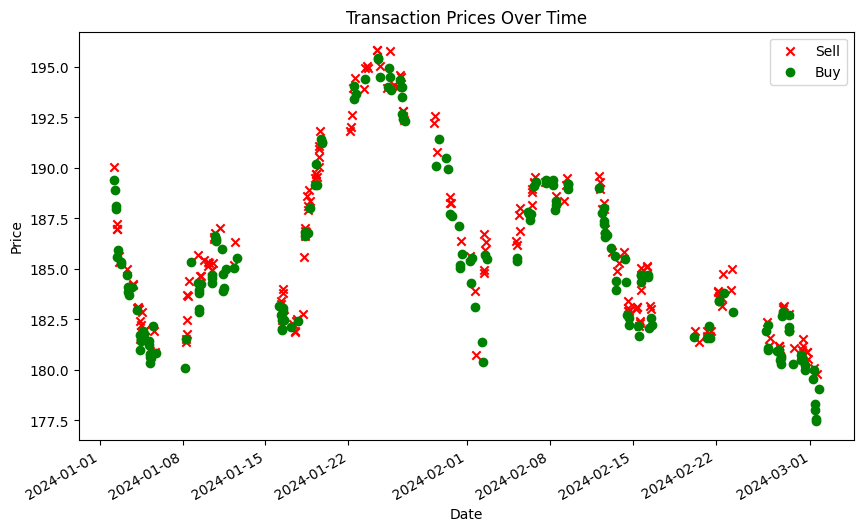

Running Simulation for RSI with AAPL from 2024-01-01 to 2024-03-01
Number of Transactions:  390
Buys:  191 Sells:  199
Open Price, Close Price:  190.2 179
Beginning Cash and Shares:  500000.0 1000
Beginning Portfolio Value:  690200.0
End Cash and Shares:  700000.0 25.215777434843943
End Portfolio Value:  704513.624160837


Model Profit Percentage:  2.073837171955525
Market Change w/o trades -1.6227180527383354
Model outperforms market by 3.6965552246938604 %
Number of Data Points: 31385
Transactions:  [['2024-01-02 06:26', 151.35, 'Buy'], ['2024-01-02 06:35', 151.12, 'Buy'], ['2024-01-02 08:01', 152.75, 'Buy'], ['2024-01-02 08:21', 150.11, 'Buy'], ['2024-01-02 09:32', 151.47, 'Sell'], ['2024-01-02 10:21', 148.97, 'Buy'], ['2024-01-02 11:18', 149.815, 'Sell'], ['2024-01-02 11:35', 150.375, 'Sell'], ['2024-01-02 11:41', 150.3598, 'Sell'], ['2024-01-02 13:01', 149.73, 'Buy'], ['2024-01-02 14:05', 149.3052, 'Buy'], ['2024-01-02 15:07', 149.145, 'Buy'], ['2024-01-02 15:54', 149.68, 'Sell'],

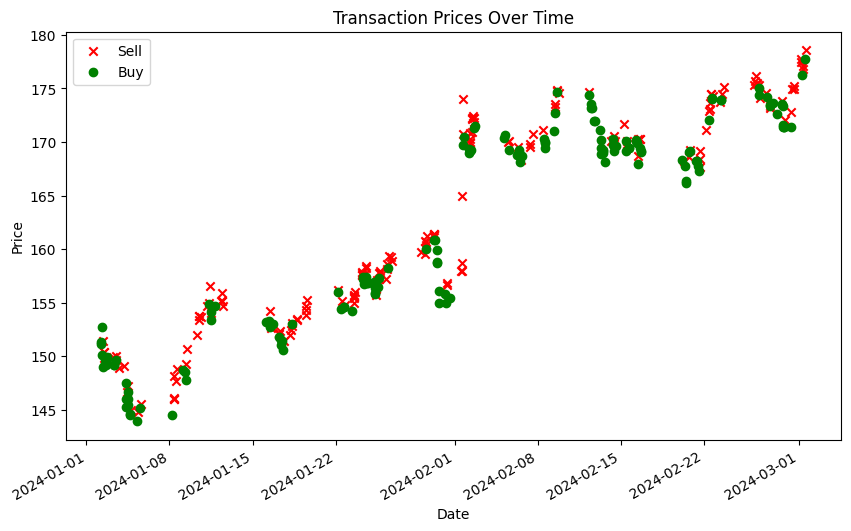

Running Simulation for RSI with AMZN from 2024-01-01 to 2024-03-01
Number of Transactions:  334
Buys:  156 Sells:  178
Open Price, Close Price:  152.65 178
Beginning Cash and Shares:  500000.0 1000
Beginning Portfolio Value:  652650.0
End Cash and Shares:  1050000.0 -2437.502398115002
End Portfolio Value:  616124.5731355296


Model Profit Percentage:  -5.596480022135962
Market Change w/o trades 3.8841645598712926
Model outperforms market by -9.480644582007255 %
Number of Data Points: 38140
Transactions:  [['2024-01-02 04:41', 249.92, 'Buy'], ['2024-01-02 05:41', 249.41, 'Buy'], ['2024-01-02 06:22', 246.49, 'Buy'], ['2024-01-02 06:31', 245.3, 'Buy'], ['2024-01-02 08:03', 245.78, 'Sell'], ['2024-01-02 08:19', 245.86, 'Buy'], ['2024-01-02 08:35', 246.85, 'Sell'], ['2024-01-02 09:35', 246.73, 'Buy'], ['2024-01-02 10:39', 247.37, 'Buy'], ['2024-01-02 12:57', 247.81, 'Buy'], ['2024-01-02 13:02', 247.3156, 'Buy'], ['2024-01-02 15:05', 247.0159, 'Buy'], ['2024-01-02 15:57', 248.3299, 'Sell'], 

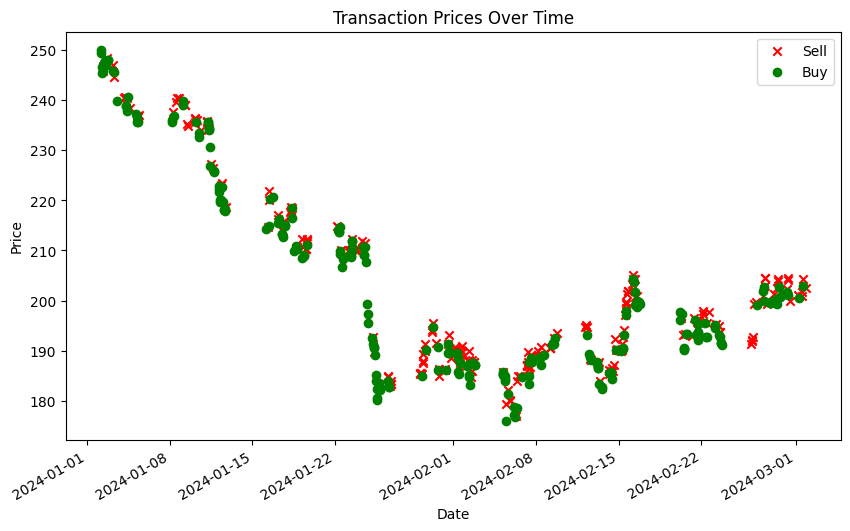

Running Simulation for RSI with TSLA from 2024-01-01 to 2024-03-01
Number of Transactions:  476
Buys:  241 Sells:  235
Open Price, Close Price:  250.88 202.27
Beginning Cash and Shares:  500000.0 1000
Beginning Portfolio Value:  750880.0
End Cash and Shares:  350000.0 1495.4138266001692
End Portfolio Value:  652477.3547064163


Model Profit Percentage:  -13.104976200402692
Market Change w/o trades -6.473737481355207
Model outperforms market by -6.631238719047485 %


In [302]:
#test
tickers = ["AAPL", "AMZN", "TSLA"]
start_date = "2024-01-01"
end_date =  "2024-03-01"
initial_portfolio_value = 1000000
for ticker in tickers:
    # replace start price with start price of stock (you can find it in yahoo finance)
    start_price = 0
    
    initial_cash = 0.5 * initial_portfolio_value
    initial_shares = (0.5 * initial_portfolio_value/start_price) if start_price > 0 else 1000
    percent_invest = 5
    alpha, profit = test_model(ticker, start_date, end_date, initial_cash, initial_shares, percent_invest) # can only run for about 3 months
    print()
    print()